In [1]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

model_name_or_path = "FacebookAI/roberta-large"
dataset_name_or_path = "stanfordnlp/snli"

config = {
    "BATCH_SIZE": 512,
    "MAX_PHYSICAL_BATCH_SIZE": 128,
    "EPOCHS": 1,
    "NUM_GLOBAL_ROUNDS": 60,
    "LOGGING_INTERVAL": 100, # once every how many steps we run evaluation cycle and report metrics
    "EPSILON": 6.0,
    "DELTA": 1e-5, # probability of not achieving privacy guarantees
    "MAX_GRAD_NORM": 10.0,
    "NUM_CLIENTS": 3,
}

In [2]:

from modules.model import get_base_model_and_tokenizer
from modules.dataset_tokenizer import tokenize_datasets
from modules.utils import partition_dataset_heterogeneous, partition_dataset_homogeneous

from torch.utils.data import DataLoader, RandomSampler
from datasets import load_dataset


# load hf datasets
hf_dataset_train = load_dataset(dataset_name_or_path, split="train[:50%]")
hf_dataset_test = load_dataset(dataset_name_or_path, split="test")

# get base model and tokenizer
base_model, tokenizer = get_base_model_and_tokenizer(model_name_or_path)

# tokenize
train_tokenized, test_tokenized = tokenize_datasets(tokenizer, hf_dataset_train, hf_dataset_test)

# data loaders
train_dataloader = DataLoader(train_tokenized, batch_size=config['BATCH_SIZE'])
test_dataloader = DataLoader(test_tokenized, sampler=RandomSampler(test_tokenized), batch_size=config['BATCH_SIZE'])

# partition the data
client_train_partitions = partition_dataset_heterogeneous(train_tokenized, num_clients=config['NUM_CLIENTS'])

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from modules.model import get_lora_model_from_base
from modules.train import federated_train

# Train vanilla LoRA version first
lora_model_lora = get_lora_model_from_base(model=base_model, vanilla_lora=True)

global_model_lora, acc_history_lora, loss_history_lora = federated_train(
    lora_model_lora,
    client_train_partitions,
    test_dataloader, 
    config,
    vanilla_lora=True,
    logging=False
)

# Train FFA-LoRA version
lora_model_ffa_lora = get_lora_model_from_base(model=base_model, vanilla_lora=False)

global_model_ffa_lora, acc_history_ffa_lora, loss_history_ffa_lora = federated_train(
    lora_model_ffa_lora,
    client_train_partitions,
    test_dataloader, 
    config,
    vanilla_lora=False,
    logging=False
)

Total parameters count: 53,151,747
Total trainable parameters with LoRA: 1,839,107
Total trainable parameters with LoRA after freezing: 786,432
Global Round 1


   Client 0 training: 802it [01:39,  8.06it/s]                          


    Local training loss: 0.680


   Client 1 training: 795it [01:39,  8.00it/s]                          


    Local training loss: 0.631


   Client 2 training: 800it [01:39,  8.05it/s]                          


    Local training loss: 0.687
After Global Round 1: Eval loss: 1.116 | Eval accuracy: 0.353
Global Round 2


   Client 0 training: 799it [01:40,  7.92it/s]                          


    Local training loss: 0.431


   Client 1 training: 805it [01:38,  8.15it/s]                          


    Local training loss: 0.428


   Client 2 training: 812it [01:38,  8.27it/s]                          


    Local training loss: 0.427
After Global Round 2: Eval loss: 1.102 | Eval accuracy: 0.364
Global Round 3


   Client 0 training: 790it [01:40,  7.82it/s]                          


    Local training loss: 0.426


   Client 1 training: 804it [01:39,  8.08it/s]                          


    Local training loss: 0.438


   Client 2 training: 816it [01:37,  8.38it/s]                          


    Local training loss: 0.434
After Global Round 3: Eval loss: 1.102 | Eval accuracy: 0.348
Global Round 4


   Client 0 training: 802it [01:38,  8.14it/s]                          


    Local training loss: 0.433


   Client 1 training: 811it [01:38,  8.27it/s]                          


    Local training loss: 0.436


   Client 2 training: 805it [01:38,  8.17it/s]                          


    Local training loss: 0.437
After Global Round 4: Eval loss: 1.099 | Eval accuracy: 0.351
Global Round 5


   Client 0 training: 803it [01:39,  8.09it/s]                          


    Local training loss: 0.418


   Client 1 training: 805it [01:39,  8.10it/s]                          


    Local training loss: 0.438


   Client 2 training: 809it [01:37,  8.26it/s]                          


    Local training loss: 0.437
After Global Round 5: Eval loss: 1.100 | Eval accuracy: 0.345
Global Round 6


   Client 0 training: 807it [01:39,  8.14it/s]                          


    Local training loss: 0.426


   Client 1 training: 794it [01:40,  7.91it/s]                          


    Local training loss: 0.438


   Client 2 training: 798it [01:39,  8.04it/s]                          


    Local training loss: 0.441
After Global Round 6: Eval loss: 1.098 | Eval accuracy: 0.347
Global Round 7


   Client 0 training: 800it [01:39,  8.03it/s]                          


    Local training loss: 0.439


   Client 1 training: 800it [01:39,  8.08it/s]                          


    Local training loss: 0.443


   Client 2 training: 814it [01:39,  8.17it/s]                          


    Local training loss: 0.446
After Global Round 7: Eval loss: 1.103 | Eval accuracy: 0.351
Global Round 8


   Client 0 training: 797it [01:40,  7.96it/s]                          


    Local training loss: 0.438


   Client 1 training: 798it [01:38,  8.06it/s]                          


    Local training loss: 0.452


   Client 2 training: 800it [01:40,  7.98it/s]                          


    Local training loss: 0.431
After Global Round 8: Eval loss: 1.096 | Eval accuracy: 0.365
Global Round 9


   Client 0 training: 798it [01:39,  8.03it/s]                          


    Local training loss: 0.443


   Client 1 training: 805it [01:39,  8.13it/s]                          


    Local training loss: 0.447


   Client 2 training: 804it [01:37,  8.25it/s]                          


    Local training loss: 0.441
After Global Round 9: Eval loss: 1.096 | Eval accuracy: 0.355
Global Round 10


   Client 0 training: 801it [01:39,  8.01it/s]                          


    Local training loss: 0.438


   Client 1 training: 803it [01:39,  8.07it/s]                          


    Local training loss: 0.440


   Client 2 training: 788it [01:40,  7.85it/s]                          


    Local training loss: 0.446
After Global Round 10: Eval loss: 1.098 | Eval accuracy: 0.352
Global Round 11


   Client 0 training: 803it [01:39,  8.11it/s]                          


    Local training loss: 0.445


   Client 1 training: 797it [01:39,  8.04it/s]                          


    Local training loss: 0.436


   Client 2 training: 802it [01:39,  8.07it/s]                          


    Local training loss: 0.451
After Global Round 11: Eval loss: 1.093 | Eval accuracy: 0.368
Global Round 12


   Client 0 training: 790it [01:40,  7.90it/s]                          


    Local training loss: 0.442


   Client 1 training: 799it [01:38,  8.13it/s]                          


    Local training loss: 0.446


   Client 2 training: 788it [01:41,  7.80it/s]                          


    Local training loss: 0.440
After Global Round 12: Eval loss: 1.094 | Eval accuracy: 0.371
Global Round 13


   Client 0 training: 796it [01:39,  8.02it/s]                          


    Local training loss: 0.442


   Client 1 training: 805it [01:38,  8.14it/s]                          


    Local training loss: 0.441


   Client 2 training: 818it [01:38,  8.34it/s]                          


    Local training loss: 0.452
After Global Round 13: Eval loss: 1.094 | Eval accuracy: 0.367
Global Round 14


   Client 0 training: 797it [01:39,  8.05it/s]                          


    Local training loss: 0.441


   Client 1 training: 798it [01:38,  8.07it/s]                          


    Local training loss: 0.455


   Client 2 training: 798it [01:38,  8.06it/s]                          


    Local training loss: 0.441
After Global Round 14: Eval loss: 1.092 | Eval accuracy: 0.377
Global Round 15


   Client 0 training: 799it [01:39,  8.06it/s]                          


    Local training loss: 0.448


   Client 1 training: 809it [01:38,  8.21it/s]                          


    Local training loss: 0.453


   Client 2 training: 808it [01:38,  8.22it/s]                          


    Local training loss: 0.444
After Global Round 15: Eval loss: 1.090 | Eval accuracy: 0.378
Global Round 16


   Client 0 training: 798it [01:38,  8.13it/s]                          


    Local training loss: 0.442


   Client 1 training: 789it [01:38,  8.01it/s]                          


    Local training loss: 0.442


   Client 2 training: 794it [01:39,  8.02it/s]                          


    Local training loss: 0.453
After Global Round 16: Eval loss: 1.089 | Eval accuracy: 0.375
Global Round 17


   Client 0 training: 802it [01:39,  8.08it/s]                          


    Local training loss: 0.451


   Client 1 training: 795it [01:38,  8.04it/s]                          


    Local training loss: 0.444


   Client 2 training: 809it [01:38,  8.20it/s]                          


    Local training loss: 0.452
After Global Round 17: Eval loss: 1.089 | Eval accuracy: 0.386
Global Round 18


   Client 0 training: 808it [01:38,  8.21it/s]                          


    Local training loss: 0.445


   Client 1 training: 798it [01:38,  8.11it/s]                          


    Local training loss: 0.447


   Client 2 training: 798it [01:39,  8.05it/s]                          


    Local training loss: 0.450
After Global Round 18: Eval loss: 1.093 | Eval accuracy: 0.357
Global Round 19


   Client 0 training: 800it [01:39,  8.06it/s]                          


    Local training loss: 0.439


   Client 1 training: 811it [01:36,  8.39it/s]                          


    Local training loss: 0.436


   Client 2 training: 799it [01:38,  8.12it/s]                          


    Local training loss: 0.446
After Global Round 19: Eval loss: 1.100 | Eval accuracy: 0.352
Global Round 20


   Client 0 training: 788it [01:40,  7.86it/s]                          


    Local training loss: 0.446


   Client 1 training: 807it [01:38,  8.22it/s]                          


    Local training loss: 0.438


   Client 2 training: 809it [01:38,  8.17it/s]                          


    Local training loss: 0.442
After Global Round 20: Eval loss: 1.098 | Eval accuracy: 0.349
Global Round 21


   Client 0 training: 792it [01:39,  8.00it/s]                          


    Local training loss: 0.446


   Client 1 training: 795it [01:38,  8.09it/s]                          


    Local training loss: 0.446


   Client 2 training: 807it [01:39,  8.14it/s]                          


    Local training loss: 0.449
After Global Round 21: Eval loss: 1.087 | Eval accuracy: 0.382
Global Round 22


   Client 0 training: 786it [01:39,  7.87it/s]                          


    Local training loss: 0.440


   Client 1 training: 794it [01:38,  8.03it/s]                          


    Local training loss: 0.447


   Client 2 training: 790it [01:39,  7.97it/s]                          


    Local training loss: 0.454
After Global Round 22: Eval loss: 1.084 | Eval accuracy: 0.386
Global Round 23


   Client 0 training: 809it [01:39,  8.14it/s]                          


    Local training loss: 0.446


   Client 1 training: 807it [01:37,  8.24it/s]                          


    Local training loss: 0.442


   Client 2 training: 801it [01:39,  8.07it/s]                          


    Local training loss: 0.450
After Global Round 23: Eval loss: 1.081 | Eval accuracy: 0.409
Global Round 24


   Client 0 training: 794it [01:39,  7.98it/s]                          


    Local training loss: 0.454


   Client 1 training: 797it [01:39,  8.02it/s]                          


    Local training loss: 0.443


   Client 2 training: 811it [01:37,  8.30it/s]                          


    Local training loss: 0.455
After Global Round 24: Eval loss: 1.091 | Eval accuracy: 0.401
Global Round 25


   Client 0 training: 806it [01:38,  8.22it/s]                          


    Local training loss: 0.450


   Client 1 training: 795it [01:38,  8.09it/s]                          


    Local training loss: 0.446


   Client 2 training: 797it [01:38,  8.10it/s]                          


    Local training loss: 0.447
After Global Round 25: Eval loss: 1.080 | Eval accuracy: 0.408
Global Round 26


   Client 0 training: 797it [01:38,  8.06it/s]                          


    Local training loss: 0.438


   Client 1 training: 791it [01:39,  7.99it/s]                          


    Local training loss: 0.441


   Client 2 training: 809it [01:37,  8.29it/s]                          


    Local training loss: 0.442
After Global Round 26: Eval loss: 1.083 | Eval accuracy: 0.380
Global Round 27


   Client 0 training: 798it [01:38,  8.12it/s]                          


    Local training loss: 0.448


   Client 1 training: 799it [01:37,  8.21it/s]                          


    Local training loss: 0.445


   Client 2 training: 815it [01:38,  8.27it/s]                          


    Local training loss: 0.446
After Global Round 27: Eval loss: 1.079 | Eval accuracy: 0.410
Global Round 28


   Client 0 training: 810it [01:38,  8.20it/s]                          


    Local training loss: 0.444


   Client 1 training: 809it [01:38,  8.22it/s]                          


    Local training loss: 0.446


   Client 2 training: 807it [01:37,  8.24it/s]                          


    Local training loss: 0.450
After Global Round 28: Eval loss: 1.080 | Eval accuracy: 0.412
Global Round 29


   Client 0 training: 789it [01:39,  7.92it/s]                          


    Local training loss: 0.452


   Client 1 training: 796it [01:38,  8.06it/s]                          


    Local training loss: 0.442


   Client 2 training: 804it [01:37,  8.21it/s]                          


    Local training loss: 0.450
After Global Round 29: Eval loss: 1.074 | Eval accuracy: 0.431
Global Round 30


   Client 0 training: 806it [01:37,  8.25it/s]                          


    Local training loss: 0.445


   Client 1 training: 811it [01:37,  8.32it/s]                          


    Local training loss: 0.447


   Client 2 training: 807it [01:38,  8.20it/s]                          


    Local training loss: 0.451
After Global Round 30: Eval loss: 1.075 | Eval accuracy: 0.419
Global Round 31


   Client 0 training: 809it [01:37,  8.31it/s]                          


    Local training loss: 0.437


   Client 1 training: 797it [01:38,  8.11it/s]                          


    Local training loss: 0.452


   Client 2 training: 801it [01:38,  8.16it/s]                          


    Local training loss: 0.445
After Global Round 31: Eval loss: 1.076 | Eval accuracy: 0.404
Global Round 32


   Client 0 training: 804it [01:39,  8.07it/s]                          


    Local training loss: 0.442


   Client 1 training: 795it [01:39,  8.03it/s]                          


    Local training loss: 0.448


   Client 2 training: 796it [01:39,  8.00it/s]                          


    Local training loss: 0.445
After Global Round 32: Eval loss: 1.083 | Eval accuracy: 0.391
Global Round 33


   Client 0 training: 804it [01:38,  8.20it/s]                          


    Local training loss: 0.446


   Client 1 training: 795it [01:38,  8.06it/s]                          


    Local training loss: 0.448


   Client 2 training: 795it [01:39,  8.02it/s]                          


    Local training loss: 0.444
After Global Round 33: Eval loss: 1.083 | Eval accuracy: 0.411
Global Round 34


   Client 0 training: 795it [01:39,  8.02it/s]                          


    Local training loss: 0.443


   Client 1 training: 793it [01:39,  7.98it/s]                          


    Local training loss: 0.459


   Client 2 training: 795it [01:39,  8.01it/s]                          


    Local training loss: 0.443
After Global Round 34: Eval loss: 1.072 | Eval accuracy: 0.428
Global Round 35


   Client 0 training: 808it [01:38,  8.22it/s]                          


    Local training loss: 0.445


   Client 1 training: 794it [01:39,  7.99it/s]                          


    Local training loss: 0.449


   Client 2 training: 805it [01:38,  8.17it/s]                          


    Local training loss: 0.446
After Global Round 35: Eval loss: 1.074 | Eval accuracy: 0.426
Global Round 36


   Client 0 training: 802it [01:38,  8.15it/s]                          


    Local training loss: 0.444


   Client 1 training: 792it [01:38,  8.00it/s]                          


    Local training loss: 0.453


   Client 2 training: 807it [01:38,  8.20it/s]                          


    Local training loss: 0.455
After Global Round 36: Eval loss: 1.074 | Eval accuracy: 0.429
Global Round 37


   Client 0 training: 798it [01:38,  8.14it/s]                          


    Local training loss: 0.440


   Client 1 training: 797it [01:38,  8.10it/s]                          


    Local training loss: 0.443


   Client 2 training: 805it [01:38,  8.19it/s]                          


    Local training loss: 0.448
After Global Round 37: Eval loss: 1.065 | Eval accuracy: 0.447
Global Round 38


   Client 0 training: 794it [01:38,  8.02it/s]                          


    Local training loss: 0.440


   Client 1 training: 798it [01:38,  8.12it/s]                          


    Local training loss: 0.449


   Client 2 training: 799it [01:38,  8.11it/s]                          


    Local training loss: 0.446
After Global Round 38: Eval loss: 1.075 | Eval accuracy: 0.408
Global Round 39


   Client 0 training: 802it [01:38,  8.14it/s]                          


    Local training loss: 0.435


   Client 1 training: 797it [01:38,  8.13it/s]                          


    Local training loss: 0.446


   Client 2 training: 797it [01:38,  8.10it/s]                          


    Local training loss: 0.445
After Global Round 39: Eval loss: 1.066 | Eval accuracy: 0.438
Global Round 40


   Client 0 training: 797it [01:37,  8.17it/s]                          


    Local training loss: 0.442


   Client 1 training: 787it [01:39,  7.93it/s]                          


    Local training loss: 0.456


   Client 2 training: 798it [01:38,  8.08it/s]                          


    Local training loss: 0.447
After Global Round 40: Eval loss: 1.067 | Eval accuracy: 0.411
Global Round 41


   Client 0 training: 796it [01:39,  7.99it/s]                          


    Local training loss: 0.449


   Client 1 training: 810it [01:37,  8.35it/s]                          


    Local training loss: 0.449


   Client 2 training: 797it [01:37,  8.14it/s]                          


    Local training loss: 0.450
After Global Round 41: Eval loss: 1.069 | Eval accuracy: 0.396
Global Round 42


   Client 0 training: 803it [01:38,  8.15it/s]                          


    Local training loss: 0.453


   Client 1 training: 793it [01:38,  8.02it/s]                          


    Local training loss: 0.447


   Client 2 training: 805it [01:39,  8.12it/s]                          


    Local training loss: 0.450
After Global Round 42: Eval loss: 1.055 | Eval accuracy: 0.458
Global Round 43


   Client 0 training: 806it [01:38,  8.14it/s]                          


    Local training loss: 0.448


   Client 1 training: 802it [01:39,  8.06it/s]                          


    Local training loss: 0.450


   Client 2 training: 798it [01:38,  8.11it/s]                          


    Local training loss: 0.456
After Global Round 43: Eval loss: 1.054 | Eval accuracy: 0.454
Global Round 44


   Client 0 training: 799it [01:38,  8.08it/s]                          


    Local training loss: 0.438


   Client 1 training: 799it [01:39,  8.06it/s]                          


    Local training loss: 0.441


   Client 2 training: 806it [01:39,  8.14it/s]                          


    Local training loss: 0.459
After Global Round 44: Eval loss: 1.052 | Eval accuracy: 0.461
Global Round 45


   Client 0 training: 803it [01:39,  8.06it/s]                          


    Local training loss: 0.455


   Client 1 training: 800it [01:37,  8.24it/s]                          


    Local training loss: 0.447


   Client 2 training: 807it [01:37,  8.27it/s]                          


    Local training loss: 0.449
After Global Round 45: Eval loss: 1.047 | Eval accuracy: 0.484
Global Round 46


   Client 0 training: 806it [01:37,  8.25it/s]                          


    Local training loss: 0.450


   Client 1 training: 792it [01:38,  8.01it/s]                          


    Local training loss: 0.448


   Client 2 training: 811it [01:38,  8.25it/s]                          


    Local training loss: 0.452
After Global Round 46: Eval loss: 1.049 | Eval accuracy: 0.465
Global Round 47


   Client 0 training: 801it [01:38,  8.10it/s]                          


    Local training loss: 0.446


   Client 1 training: 788it [01:39,  7.92it/s]                          


    Local training loss: 0.444


   Client 2 training: 800it [01:37,  8.18it/s]                          


    Local training loss: 0.446
After Global Round 47: Eval loss: 1.043 | Eval accuracy: 0.490
Global Round 48


   Client 0 training: 791it [01:38,  8.00it/s]                          


    Local training loss: 0.447


   Client 1 training: 814it [01:37,  8.35it/s]                          


    Local training loss: 0.454


   Client 2 training: 807it [01:38,  8.20it/s]                          


    Local training loss: 0.448
After Global Round 48: Eval loss: 1.047 | Eval accuracy: 0.460
Global Round 49


   Client 0 training: 799it [01:38,  8.09it/s]                          


    Local training loss: 0.454


   Client 1 training: 800it [01:38,  8.09it/s]                          


    Local training loss: 0.457


   Client 2 training: 803it [01:37,  8.25it/s]                          


    Local training loss: 0.454
After Global Round 49: Eval loss: 1.039 | Eval accuracy: 0.495
Global Round 50


   Client 0 training: 797it [01:38,  8.07it/s]                          


    Local training loss: 0.449


   Client 1 training: 791it [01:38,  8.04it/s]                          


    Local training loss: 0.450


   Client 2 training: 795it [01:38,  8.06it/s]                          


    Local training loss: 0.461
After Global Round 50: Eval loss: 1.049 | Eval accuracy: 0.461
Global Round 51


   Client 0 training: 803it [01:39,  8.08it/s]                          


    Local training loss: 0.453


   Client 1 training: 813it [01:37,  8.38it/s]                          


    Local training loss: 0.454


   Client 2 training: 804it [01:39,  8.11it/s]                          


    Local training loss: 0.461
After Global Round 51: Eval loss: 1.033 | Eval accuracy: 0.499
Global Round 52


   Client 0 training: 796it [01:37,  8.16it/s]                          


    Local training loss: 0.447


   Client 1 training: 792it [01:39,  7.95it/s]                          


    Local training loss: 0.444


   Client 2 training: 809it [01:38,  8.25it/s]                          


    Local training loss: 0.453
After Global Round 52: Eval loss: 1.031 | Eval accuracy: 0.498
Global Round 53


   Client 0 training: 795it [01:38,  8.06it/s]                          


    Local training loss: 0.445


   Client 1 training: 807it [01:37,  8.26it/s]                          


    Local training loss: 0.451


   Client 2 training: 795it [01:38,  8.06it/s]                          


    Local training loss: 0.454
After Global Round 53: Eval loss: 1.027 | Eval accuracy: 0.504
Global Round 54


   Client 0 training: 810it [01:38,  8.24it/s]                          


    Local training loss: 0.459


   Client 1 training: 798it [01:38,  8.12it/s]                          


    Local training loss: 0.456


   Client 2 training: 801it [01:37,  8.20it/s]                          


    Local training loss: 0.450
After Global Round 54: Eval loss: 1.022 | Eval accuracy: 0.521
Global Round 55


   Client 0 training: 799it [01:39,  8.05it/s]                          


    Local training loss: 0.442


   Client 1 training: 794it [01:38,  8.02it/s]                          


    Local training loss: 0.455


   Client 2 training: 807it [01:38,  8.20it/s]                          


    Local training loss: 0.447
After Global Round 55: Eval loss: 1.020 | Eval accuracy: 0.518
Global Round 56


   Client 0 training: 807it [01:37,  8.24it/s]                          


    Local training loss: 0.446


   Client 1 training: 793it [01:38,  8.09it/s]                          


    Local training loss: 0.441


   Client 2 training: 800it [01:39,  8.07it/s]                          


    Local training loss: 0.455
After Global Round 56: Eval loss: 1.017 | Eval accuracy: 0.524
Global Round 57


   Client 0 training: 799it [01:39,  8.02it/s]                          


    Local training loss: 0.444


   Client 1 training: 783it [01:39,  7.86it/s]                          


    Local training loss: 0.450


   Client 2 training: 794it [01:38,  8.07it/s]                          


    Local training loss: 0.457
After Global Round 57: Eval loss: 1.018 | Eval accuracy: 0.498
Global Round 58


   Client 0 training: 785it [01:40,  7.84it/s]                          


    Local training loss: 0.444


   Client 1 training: 801it [01:38,  8.12it/s]                          


    Local training loss: 0.453


   Client 2 training: 807it [01:37,  8.29it/s]                          


    Local training loss: 0.461
After Global Round 58: Eval loss: 1.009 | Eval accuracy: 0.530
Global Round 59


   Client 0 training: 801it [01:37,  8.20it/s]                          


    Local training loss: 0.455


   Client 1 training: 798it [01:38,  8.08it/s]                          


    Local training loss: 0.450


   Client 2 training: 798it [01:39,  8.06it/s]                          


    Local training loss: 0.447
After Global Round 59: Eval loss: 1.011 | Eval accuracy: 0.506
Global Round 60


   Client 0 training: 800it [01:38,  8.10it/s]                          


    Local training loss: 0.453


   Client 1 training: 805it [01:38,  8.16it/s]                          


    Local training loss: 0.448


   Client 2 training: 793it [01:39,  7.94it/s]                          


    Local training loss: 0.457
After Global Round 60: Eval loss: 0.996 | Eval accuracy: 0.554
Total parameters count: 53,151,747
Total trainable parameters with LoRA: 1,839,107
Total trainable parameters with LoRA after freezing: 393,216
Global Round 1


   Client 0 training: 799it [01:28,  9.07it/s]                          


    Local training loss: 0.503


   Client 1 training: 804it [01:28,  9.06it/s]                          


    Local training loss: 0.497


   Client 2 training: 800it [01:27,  9.10it/s]                          


    Local training loss: 0.497
After Global Round 1: Eval loss: 1.106 | Eval accuracy: 0.370
Global Round 2


   Client 0 training: 800it [01:28,  9.05it/s]                          


    Local training loss: 0.420


   Client 1 training: 790it [01:29,  8.83it/s]                          


    Local training loss: 0.421


   Client 2 training: 799it [01:28,  9.04it/s]                          


    Local training loss: 0.432
After Global Round 2: Eval loss: 1.102 | Eval accuracy: 0.372
Global Round 3


   Client 0 training: 809it [01:28,  9.16it/s]                          


    Local training loss: 0.427


   Client 1 training: 798it [01:26,  9.19it/s]                          


    Local training loss: 0.425


   Client 2 training: 800it [01:28,  9.06it/s]                          


    Local training loss: 0.425
After Global Round 3: Eval loss: 1.095 | Eval accuracy: 0.361
Global Round 4


   Client 0 training: 801it [01:28,  9.04it/s]                          


    Local training loss: 0.420


   Client 1 training: 794it [01:28,  8.93it/s]                          


    Local training loss: 0.415


   Client 2 training: 805it [01:27,  9.20it/s]                          


    Local training loss: 0.422
After Global Round 4: Eval loss: 1.093 | Eval accuracy: 0.355
Global Round 5


   Client 0 training: 796it [01:28,  9.03it/s]                          


    Local training loss: 0.413


   Client 1 training: 799it [01:28,  9.01it/s]                          


    Local training loss: 0.419


   Client 2 training: 792it [01:29,  8.88it/s]                          


    Local training loss: 0.410
After Global Round 5: Eval loss: 1.091 | Eval accuracy: 0.406
Global Round 6


   Client 0 training: 797it [01:27,  9.06it/s]                          


    Local training loss: 0.406


   Client 1 training: 814it [01:28,  9.24it/s]                          


    Local training loss: 0.408


   Client 2 training: 797it [01:28,  9.00it/s]                          


    Local training loss: 0.415
After Global Round 6: Eval loss: 1.087 | Eval accuracy: 0.386
Global Round 7


   Client 0 training: 792it [01:28,  8.94it/s]                          


    Local training loss: 0.411


   Client 1 training: 799it [01:27,  9.12it/s]                          


    Local training loss: 0.405


   Client 2 training: 803it [01:27,  9.19it/s]                          


    Local training loss: 0.415
After Global Round 7: Eval loss: 1.094 | Eval accuracy: 0.344
Global Round 8


   Client 0 training: 803it [01:28,  9.11it/s]                          


    Local training loss: 0.413


   Client 1 training: 810it [01:26,  9.32it/s]                          


    Local training loss: 0.406


   Client 2 training: 797it [01:28,  9.02it/s]                          


    Local training loss: 0.410
After Global Round 8: Eval loss: 1.082 | Eval accuracy: 0.410
Global Round 9


   Client 0 training: 800it [01:28,  9.04it/s]                          


    Local training loss: 0.405


   Client 1 training: 799it [01:28,  9.01it/s]                          


    Local training loss: 0.406


   Client 2 training: 803it [01:27,  9.21it/s]                          


    Local training loss: 0.415
After Global Round 9: Eval loss: 1.080 | Eval accuracy: 0.404
Global Round 10


   Client 0 training: 796it [01:27,  9.05it/s]                          


    Local training loss: 0.406


   Client 1 training: 798it [01:27,  9.07it/s]                          


    Local training loss: 0.405


   Client 2 training: 797it [01:28,  9.02it/s]                          


    Local training loss: 0.408
After Global Round 10: Eval loss: 1.077 | Eval accuracy: 0.380
Global Round 11


   Client 0 training: 797it [01:29,  8.94it/s]                          


    Local training loss: 0.401


   Client 1 training: 803it [01:28,  9.08it/s]                          


    Local training loss: 0.410


   Client 2 training: 803it [01:28,  9.11it/s]                          


    Local training loss: 0.407
After Global Round 11: Eval loss: 1.064 | Eval accuracy: 0.485
Global Round 12


   Client 0 training: 798it [01:28,  9.04it/s]                          


    Local training loss: 0.401


   Client 1 training: 795it [01:28,  9.02it/s]                          


    Local training loss: 0.400


   Client 2 training: 793it [01:28,  8.96it/s]                          


    Local training loss: 0.400
After Global Round 12: Eval loss: 1.061 | Eval accuracy: 0.448
Global Round 13


   Client 0 training: 811it [01:26,  9.33it/s]                          


    Local training loss: 0.401


   Client 1 training: 804it [01:28,  9.09it/s]                          


    Local training loss: 0.399


   Client 2 training: 810it [01:27,  9.28it/s]                          


    Local training loss: 0.404
After Global Round 13: Eval loss: 1.052 | Eval accuracy: 0.432
Global Round 14


   Client 0 training: 811it [01:27,  9.30it/s]                          


    Local training loss: 0.398


   Client 1 training: 794it [01:26,  9.13it/s]                          


    Local training loss: 0.407


   Client 2 training: 803it [01:27,  9.18it/s]                          


    Local training loss: 0.393
After Global Round 14: Eval loss: 1.030 | Eval accuracy: 0.521
Global Round 15


   Client 0 training: 796it [01:29,  8.92it/s]                          


    Local training loss: 0.396


   Client 1 training: 814it [01:26,  9.37it/s]                          


    Local training loss: 0.400


   Client 2 training: 806it [01:27,  9.16it/s]                          


    Local training loss: 0.391
After Global Round 15: Eval loss: 1.008 | Eval accuracy: 0.508
Global Round 16


   Client 0 training: 815it [01:27,  9.30it/s]                          


    Local training loss: 0.392


   Client 1 training: 795it [01:28,  9.01it/s]                          


    Local training loss: 0.399


   Client 2 training: 818it [01:26,  9.42it/s]                          


    Local training loss: 0.384
After Global Round 16: Eval loss: 0.956 | Eval accuracy: 0.572
Global Round 17


   Client 0 training: 806it [01:27,  9.21it/s]                          


    Local training loss: 0.373


   Client 1 training: 796it [01:29,  8.94it/s]                          


    Local training loss: 0.386


   Client 2 training: 808it [01:27,  9.25it/s]                          


    Local training loss: 0.367
After Global Round 17: Eval loss: 0.863 | Eval accuracy: 0.631
Global Round 18


   Client 0 training: 804it [01:27,  9.16it/s]                          


    Local training loss: 0.351


   Client 1 training: 786it [01:29,  8.78it/s]                          


    Local training loss: 0.381


   Client 2 training: 810it [01:27,  9.30it/s]                          


    Local training loss: 0.342
After Global Round 18: Eval loss: 0.763 | Eval accuracy: 0.644
Global Round 19


   Client 0 training: 794it [01:28,  8.95it/s]                          


    Local training loss: 0.315


   Client 1 training: 809it [01:27,  9.26it/s]                          


    Local training loss: 0.355


   Client 2 training: 808it [01:28,  9.14it/s]                          


    Local training loss: 0.305
After Global Round 19: Eval loss: 0.674 | Eval accuracy: 0.696
Global Round 20


   Client 0 training: 800it [01:28,  9.00it/s]                          


    Local training loss: 0.295


   Client 1 training: 807it [01:27,  9.20it/s]                          


    Local training loss: 0.334


   Client 2 training: 797it [01:28,  9.00it/s]                          


    Local training loss: 0.280
After Global Round 20: Eval loss: 0.625 | Eval accuracy: 0.721
Global Round 21


   Client 0 training: 808it [01:28,  9.17it/s]                          


    Local training loss: 0.273


   Client 1 training: 795it [01:27,  9.06it/s]                          


    Local training loss: 0.319


   Client 2 training: 798it [01:28,  9.00it/s]                          


    Local training loss: 0.270
After Global Round 21: Eval loss: 0.579 | Eval accuracy: 0.747
Global Round 22


   Client 0 training: 799it [01:28,  9.08it/s]                          


    Local training loss: 0.264


   Client 1 training: 808it [01:27,  9.22it/s]                          


    Local training loss: 0.307


   Client 2 training: 800it [01:27,  9.13it/s]                          


    Local training loss: 0.256
After Global Round 22: Eval loss: 0.547 | Eval accuracy: 0.778
Global Round 23


   Client 0 training: 789it [01:28,  8.95it/s]                          


    Local training loss: 0.259


   Client 1 training: 815it [01:27,  9.27it/s]                          


    Local training loss: 0.296


   Client 2 training: 815it [01:27,  9.36it/s]                          


    Local training loss: 0.248
After Global Round 23: Eval loss: 0.509 | Eval accuracy: 0.799
Global Round 24


   Client 0 training: 797it [01:28,  9.02it/s]                          


    Local training loss: 0.246


   Client 1 training: 788it [01:28,  8.92it/s]                          


    Local training loss: 0.292


   Client 2 training: 810it [01:27,  9.29it/s]                          


    Local training loss: 0.240
After Global Round 24: Eval loss: 0.484 | Eval accuracy: 0.813
Global Round 25


   Client 0 training: 810it [01:27,  9.25it/s]                          


    Local training loss: 0.236


   Client 1 training: 793it [01:29,  8.90it/s]                          


    Local training loss: 0.283


   Client 2 training: 803it [01:28,  9.09it/s]                          


    Local training loss: 0.236
After Global Round 25: Eval loss: 0.465 | Eval accuracy: 0.822
Global Round 26


   Client 0 training: 797it [01:29,  8.94it/s]                          


    Local training loss: 0.231


   Client 1 training: 807it [01:27,  9.20it/s]                          


    Local training loss: 0.269


   Client 2 training: 816it [01:27,  9.33it/s]                          


    Local training loss: 0.238
After Global Round 26: Eval loss: 0.454 | Eval accuracy: 0.829
Global Round 27


   Client 0 training: 798it [01:27,  9.07it/s]                          


    Local training loss: 0.225


   Client 1 training: 800it [01:28,  9.09it/s]                          


    Local training loss: 0.269


   Client 2 training: 793it [01:28,  8.98it/s]                          


    Local training loss: 0.224
After Global Round 27: Eval loss: 0.433 | Eval accuracy: 0.840
Global Round 28


   Client 0 training: 807it [01:28,  9.17it/s]                          


    Local training loss: 0.215


   Client 1 training: 801it [01:28,  9.08it/s]                          


    Local training loss: 0.262


   Client 2 training: 800it [01:28,  9.04it/s]                          


    Local training loss: 0.217
After Global Round 28: Eval loss: 0.433 | Eval accuracy: 0.846
Global Round 29


   Client 0 training: 793it [01:28,  8.94it/s]                          


    Local training loss: 0.212


   Client 1 training: 790it [01:29,  8.87it/s]                          


    Local training loss: 0.262


   Client 2 training: 811it [01:26,  9.34it/s]                          


    Local training loss: 0.217
After Global Round 29: Eval loss: 0.428 | Eval accuracy: 0.848
Global Round 30


   Client 0 training: 793it [01:29,  8.91it/s]                          


    Local training loss: 0.204


   Client 1 training: 807it [01:27,  9.27it/s]                          


    Local training loss: 0.261


   Client 2 training: 805it [01:27,  9.19it/s]                          


    Local training loss: 0.215
After Global Round 30: Eval loss: 0.417 | Eval accuracy: 0.854
Global Round 31


   Client 0 training: 796it [01:29,  8.92it/s]                          


    Local training loss: 0.202


   Client 1 training: 797it [01:27,  9.07it/s]                          


    Local training loss: 0.253


   Client 2 training: 800it [01:27,  9.11it/s]                          


    Local training loss: 0.215
After Global Round 31: Eval loss: 0.416 | Eval accuracy: 0.856
Global Round 32


   Client 0 training: 799it [01:28,  9.02it/s]                          


    Local training loss: 0.205


   Client 1 training: 801it [01:28,  9.08it/s]                          


    Local training loss: 0.252


   Client 2 training: 797it [01:28,  8.96it/s]                          


    Local training loss: 0.210
After Global Round 32: Eval loss: 0.409 | Eval accuracy: 0.861
Global Round 33


   Client 0 training: 808it [01:27,  9.21it/s]                          


    Local training loss: 0.208


   Client 1 training: 807it [01:26,  9.29it/s]                          


    Local training loss: 0.252


   Client 2 training: 811it [01:28,  9.20it/s]                          


    Local training loss: 0.215
After Global Round 33: Eval loss: 0.414 | Eval accuracy: 0.860
Global Round 34


   Client 0 training: 794it [01:29,  8.92it/s]                          


    Local training loss: 0.202


   Client 1 training: 796it [01:29,  8.94it/s]                          


    Local training loss: 0.246


   Client 2 training: 797it [01:27,  9.07it/s]                          


    Local training loss: 0.209
After Global Round 34: Eval loss: 0.414 | Eval accuracy: 0.860
Global Round 35


   Client 0 training: 801it [01:27,  9.13it/s]                          


    Local training loss: 0.193


   Client 1 training: 798it [01:28,  9.00it/s]                          


    Local training loss: 0.242


   Client 2 training: 803it [01:26,  9.26it/s]                          


    Local training loss: 0.204
After Global Round 35: Eval loss: 0.405 | Eval accuracy: 0.865
Global Round 36


   Client 0 training: 803it [01:28,  9.07it/s]                          


    Local training loss: 0.198


   Client 1 training: 804it [01:27,  9.21it/s]                          


    Local training loss: 0.240


   Client 2 training: 803it [01:28,  9.12it/s]                          


    Local training loss: 0.202
After Global Round 36: Eval loss: 0.394 | Eval accuracy: 0.868
Global Round 37


   Client 0 training: 807it [01:27,  9.21it/s]                          


    Local training loss: 0.194


   Client 1 training: 807it [01:27,  9.22it/s]                          


    Local training loss: 0.235


   Client 2 training: 811it [01:27,  9.26it/s]                          


    Local training loss: 0.201
After Global Round 37: Eval loss: 0.397 | Eval accuracy: 0.867
Global Round 38


   Client 0 training: 799it [01:27,  9.13it/s]                          


    Local training loss: 0.192


   Client 1 training: 799it [01:28,  9.04it/s]                          


    Local training loss: 0.237


   Client 2 training: 799it [01:28,  9.02it/s]                          


    Local training loss: 0.201
After Global Round 38: Eval loss: 0.399 | Eval accuracy: 0.866
Global Round 39


   Client 0 training: 798it [01:28,  9.04it/s]                          


    Local training loss: 0.192


   Client 1 training: 810it [01:28,  9.18it/s]                          


    Local training loss: 0.238


   Client 2 training: 799it [01:28,  9.03it/s]                          


    Local training loss: 0.200
After Global Round 39: Eval loss: 0.399 | Eval accuracy: 0.870
Global Round 40


   Client 0 training: 812it [01:27,  9.33it/s]                          


    Local training loss: 0.189


   Client 1 training: 797it [01:27,  9.10it/s]                          


    Local training loss: 0.236


   Client 2 training: 805it [01:27,  9.18it/s]                          


    Local training loss: 0.202
After Global Round 40: Eval loss: 0.408 | Eval accuracy: 0.868
Global Round 41


   Client 0 training: 796it [01:29,  8.89it/s]                          


    Local training loss: 0.189


   Client 1 training: 805it [01:26,  9.27it/s]                          


    Local training loss: 0.241


   Client 2 training: 786it [01:29,  8.76it/s]                          


    Local training loss: 0.195
After Global Round 41: Eval loss: 0.403 | Eval accuracy: 0.867
Global Round 42


   Client 0 training: 790it [01:29,  8.85it/s]                          


    Local training loss: 0.180


   Client 1 training: 796it [01:28,  8.98it/s]                          


    Local training loss: 0.234


   Client 2 training: 810it [01:28,  9.19it/s]                          


    Local training loss: 0.197
After Global Round 42: Eval loss: 0.395 | Eval accuracy: 0.871
Global Round 43


   Client 0 training: 804it [01:28,  9.10it/s]                          


    Local training loss: 0.187


   Client 1 training: 806it [01:28,  9.14it/s]                          


    Local training loss: 0.233


   Client 2 training: 798it [01:28,  8.99it/s]                          


    Local training loss: 0.194
After Global Round 43: Eval loss: 0.399 | Eval accuracy: 0.871
Global Round 44


   Client 0 training: 800it [01:28,  9.06it/s]                          


    Local training loss: 0.187


   Client 1 training: 815it [01:27,  9.35it/s]                          


    Local training loss: 0.230


   Client 2 training: 806it [01:26,  9.27it/s]                          


    Local training loss: 0.195
After Global Round 44: Eval loss: 0.394 | Eval accuracy: 0.870
Global Round 45


   Client 0 training: 804it [01:27,  9.18it/s]                          


    Local training loss: 0.189


   Client 1 training: 794it [01:27,  9.03it/s]                          


    Local training loss: 0.234


   Client 2 training: 819it [01:26,  9.49it/s]                          


    Local training loss: 0.191
After Global Round 45: Eval loss: 0.393 | Eval accuracy: 0.872
Global Round 46


   Client 0 training: 802it [01:28,  9.08it/s]                          


    Local training loss: 0.187


   Client 1 training: 812it [01:27,  9.26it/s]                          


    Local training loss: 0.227


   Client 2 training: 811it [01:27,  9.28it/s]                          


    Local training loss: 0.194
After Global Round 46: Eval loss: 0.392 | Eval accuracy: 0.875
Global Round 47


   Client 0 training: 795it [01:29,  8.91it/s]                          


    Local training loss: 0.184


   Client 1 training: 810it [01:27,  9.25it/s]                          


    Local training loss: 0.230


   Client 2 training: 804it [01:28,  9.08it/s]                          


    Local training loss: 0.189
After Global Round 47: Eval loss: 0.389 | Eval accuracy: 0.875
Global Round 48


   Client 0 training: 802it [01:27,  9.18it/s]                          


    Local training loss: 0.182


   Client 1 training: 804it [01:27,  9.22it/s]                          


    Local training loss: 0.230


   Client 2 training: 795it [01:29,  8.93it/s]                          


    Local training loss: 0.189
After Global Round 48: Eval loss: 0.388 | Eval accuracy: 0.876
Global Round 49


   Client 0 training: 801it [01:27,  9.13it/s]                          


    Local training loss: 0.181


   Client 1 training: 800it [01:28,  9.06it/s]                          


    Local training loss: 0.225


   Client 2 training: 803it [01:28,  9.08it/s]                          


    Local training loss: 0.189
After Global Round 49: Eval loss: 0.387 | Eval accuracy: 0.874
Global Round 50


   Client 0 training: 798it [01:27,  9.09it/s]                          


    Local training loss: 0.180


   Client 1 training: 794it [01:28,  8.94it/s]                          


    Local training loss: 0.227


   Client 2 training: 794it [01:29,  8.89it/s]                          


    Local training loss: 0.189
After Global Round 50: Eval loss: 0.384 | Eval accuracy: 0.876
Global Round 51


   Client 0 training: 802it [01:28,  9.08it/s]                          


    Local training loss: 0.180


   Client 1 training: 802it [01:27,  9.11it/s]                          


    Local training loss: 0.227


   Client 2 training: 806it [01:27,  9.26it/s]                          


    Local training loss: 0.191
After Global Round 51: Eval loss: 0.385 | Eval accuracy: 0.877
Global Round 52


   Client 0 training: 811it [01:28,  9.17it/s]                          


    Local training loss: 0.184


   Client 1 training: 804it [01:27,  9.19it/s]                          


    Local training loss: 0.229


   Client 2 training: 808it [01:27,  9.21it/s]                          


    Local training loss: 0.190
After Global Round 52: Eval loss: 0.387 | Eval accuracy: 0.875
Global Round 53


   Client 0 training: 811it [01:27,  9.29it/s]                          


    Local training loss: 0.178


   Client 1 training: 808it [01:27,  9.22it/s]                          


    Local training loss: 0.225


   Client 2 training: 801it [01:28,  9.02it/s]                          


    Local training loss: 0.185
After Global Round 53: Eval loss: 0.385 | Eval accuracy: 0.876
Global Round 54


   Client 0 training: 810it [01:27,  9.27it/s]                          


    Local training loss: 0.187


   Client 1 training: 804it [01:27,  9.14it/s]                          


    Local training loss: 0.227


   Client 2 training: 796it [01:27,  9.06it/s]                          


    Local training loss: 0.187
After Global Round 54: Eval loss: 0.383 | Eval accuracy: 0.877
Global Round 55


   Client 0 training: 803it [01:28,  9.06it/s]                          


    Local training loss: 0.183


   Client 1 training: 794it [01:29,  8.90it/s]                          


    Local training loss: 0.225


   Client 2 training: 812it [01:28,  9.16it/s]                          


    Local training loss: 0.189
After Global Round 55: Eval loss: 0.390 | Eval accuracy: 0.874
Global Round 56


   Client 0 training: 786it [01:29,  8.82it/s]                          


    Local training loss: 0.179


   Client 1 training: 803it [01:28,  9.11it/s]                          


    Local training loss: 0.228


   Client 2 training: 801it [01:28,  9.02it/s]                          


    Local training loss: 0.186
After Global Round 56: Eval loss: 0.379 | Eval accuracy: 0.877
Global Round 57


   Client 0 training: 800it [01:28,  9.07it/s]                          


    Local training loss: 0.179


   Client 1 training: 797it [01:28,  8.96it/s]                          


    Local training loss: 0.221


   Client 2 training: 797it [01:28,  9.00it/s]                          


    Local training loss: 0.186
After Global Round 57: Eval loss: 0.386 | Eval accuracy: 0.876
Global Round 58


   Client 0 training: 796it [01:28,  9.00it/s]                          


    Local training loss: 0.175


   Client 1 training: 792it [01:28,  8.93it/s]                          


    Local training loss: 0.222


   Client 2 training: 804it [01:28,  9.10it/s]                          


    Local training loss: 0.188
After Global Round 58: Eval loss: 0.386 | Eval accuracy: 0.875
Global Round 59


   Client 0 training: 800it [01:28,  8.99it/s]                          


    Local training loss: 0.179


   Client 1 training: 799it [01:28,  9.07it/s]                          


    Local training loss: 0.222


   Client 2 training: 810it [01:25,  9.42it/s]                          


    Local training loss: 0.183
After Global Round 59: Eval loss: 0.383 | Eval accuracy: 0.878
Global Round 60


   Client 0 training: 798it [01:28,  9.05it/s]                          


    Local training loss: 0.177


   Client 1 training: 805it [01:27,  9.19it/s]                          


    Local training loss: 0.221


   Client 2 training: 805it [01:28,  9.12it/s]                          


    Local training loss: 0.185
After Global Round 60: Eval loss: 0.381 | Eval accuracy: 0.880


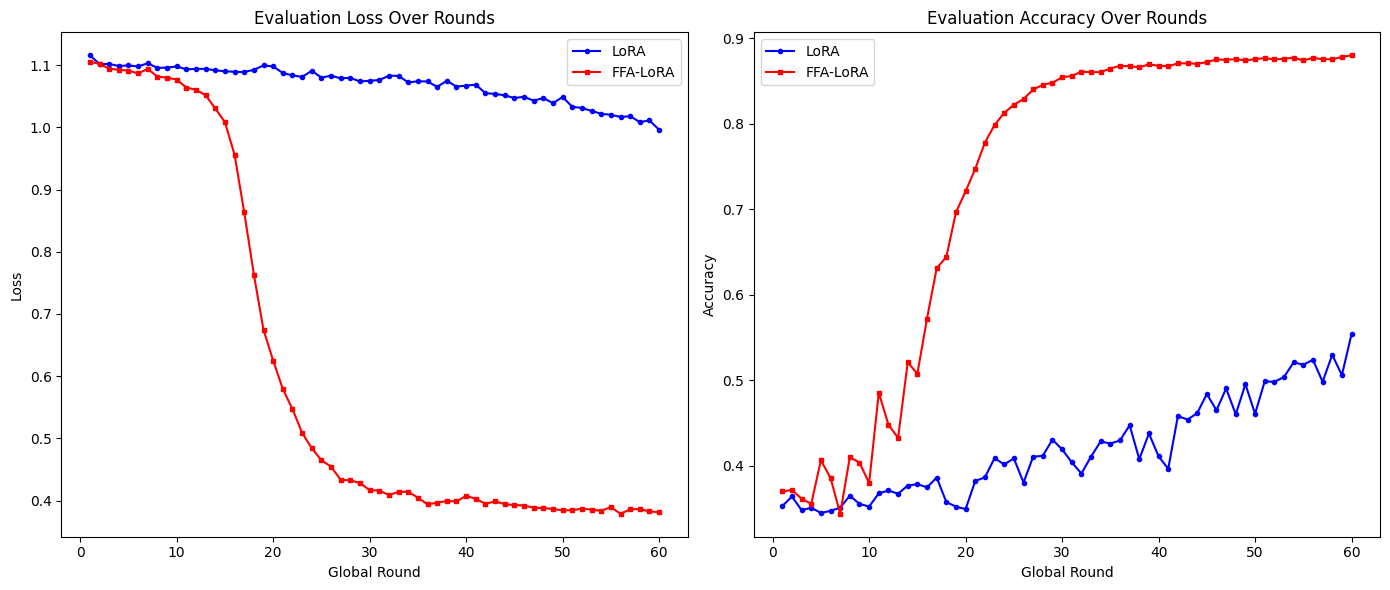

In [4]:
from modules.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    loss_history_lora,
    loss_history_ffa_lora,
    acc_history_lora,
    acc_history_ffa_lora
)